# Stanford Cars Dataset Exploratory Analysis

This notebook contains basic exploratory analysis and baseline model building of the Stanford Cars Dataset.

![](https://ai.stanford.edu/~jkrause/cars/class_montage.jpg)

Fine-grained recognition is a growing subfield of computer vision that has many real-world applications on distinguishing subtle appearances differences.

**Dataset**: The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, ex. 2012 Tesla Model S or 2012 BMW M3 coupe.

 TL;DR 
 
 - Accuracy of 84.35% on the test set
 - Finetuned the whole model ( ResNet 50 )

In [1]:
from __future__ import print_function, division
import scipy as sp
import os
import pandas as pd
import numpy as np

import time
import copy

import scipy.ndimage as spi
from skimage import io, transform

from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser


import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

print(os.listdir("../input"))
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

# Any results you write to the current directory are saved as output.

['stanford-car-dataset-by-classes-folder', 'pytorch-pretrained-image-models']
PyTorch Version:  1.1.0
Torchvision Version:  0.3.0


** Import Datasets**

In [2]:
train = pd.read_csv('../input/stanford-car-dataset-by-classes-folder/anno_train.csv',names = ['image_file','x1','x2','x3','x4','car_model'])
test = pd.read_csv('../input/stanford-car-dataset-by-classes-folder/anno_test.csv',names = ['image_file','x1','x2','x3','x4','car_model'])
names_df = pd.read_csv('../input/stanford-car-dataset-by-classes-folder/names.csv',names = ['car_model'])

print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')
print(f'Names of cars dataframe shape: {test.shape}')

Train shape: (8144, 6)
Test shape: (8041, 6)
Names of cars dataframe shape: (8041, 6)


In [3]:
train.head()

,image_file,x1,x2,x3,x4,car_model
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106


In [4]:
test.head()

,image_file,x1,x2,x3,x4,car_model
0,00001.jpg,30,52,246,147,181
1,00002.jpg,100,19,576,203,103
2,00003.jpg,51,105,968,659,145
3,00004.jpg,67,84,581,407,187
4,00005.jpg,140,151,593,339,185


In [5]:
names_df.head()

,car_model
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012


In [6]:
names_df.index = range(1,len(names_df)+1)

In [7]:
model_dict = names_df.to_dict()

In [8]:
train['car_model'] = train['car_model'].apply(lambda x:model_dict['car_model'][x])
test['car_model'] = test['car_model'].apply(lambda x:model_dict['car_model'][x])

In [9]:
train.tail(2)

,image_file,x1,x2,x3,x4,car_model
8142,08143.jpg,78,526,1489,908,Ford GT Coupe 2006
8143,08144.jpg,20,240,862,677,Audi 100 Sedan 1994


In [10]:
# Add the relative path to image file

train['image_file'] = train['car_model'] + '/' + train['image_file']
test['image_file'] = test['car_model'] + '/' + test['image_file']

In [11]:
train['image_file'][0]

'Audi TTS Coupe 2012/00001.jpg'

In [12]:
# This function prepares a random batch from the dataset
def load_batch(dataset_df, batch_size = 25):
    batch_df = dataset_df.loc[np.random.permutation(np.arange(0,
                                                              len(dataset_df)))[:batch_size],:]
    return batch_df

In [13]:
# This function plots sample images in specified size and in defined grid
def plot_batch(images_df, grid_width, grid_height, im_scale_x, im_scale_y):
    f, ax = plt.subplots(grid_width, grid_height)
    f.set_size_inches(12, 12)
    
    img_idx = 0
    for i in range(0, grid_width):
        for j in range(0, grid_height):
            ax[i][j].axis('off')
            ax[i][j].set_title(images_df.iloc[img_idx]['car_model'][:10])
            ax[i][j].imshow(sp.misc.imresize(spi.imread(DATASET_PATH + images_df.iloc[img_idx]['image_file']),
                                             (im_scale_x,im_scale_y)))
            img_idx += 1
            
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.25)

In [14]:
DATASET_PATH = r'../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/'
LABEL_PATH = r'../input/stanford-car-dataset-by-classes-folder/anno_train.csv'

**Visualize the batch dataset**

In [15]:
batch_df = load_batch(train, 
                    batch_size=36)

FileNotFoundError: [Errno 2] No such file or directory: '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Ram C/V Cargo Van Minivan 2012/02815.jpg'

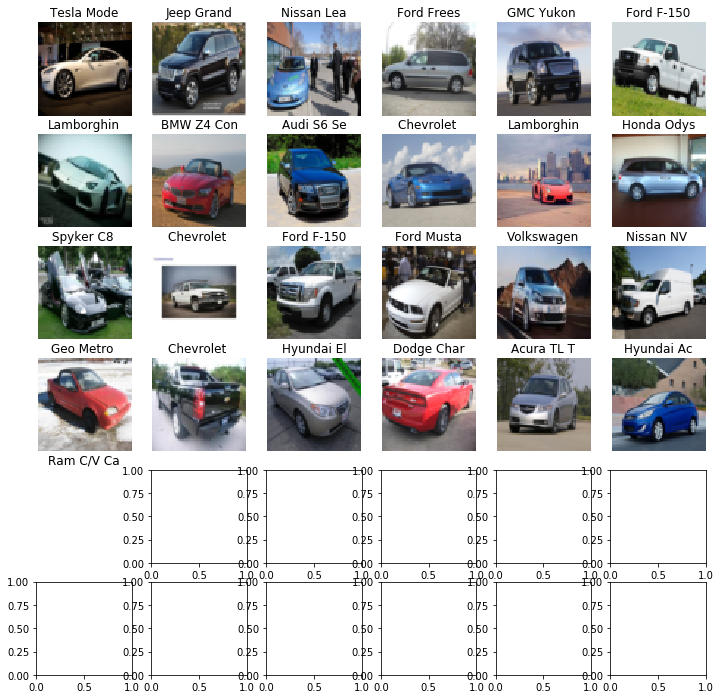

In [16]:
plot_batch(batch_df, grid_width=6, grid_height=6
           ,im_scale_x=64, im_scale_y=64)


As we can see that a lot of images contains texts and other unnecessary stuffs in images.

# Model Building

**Baseline Model**

In [17]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/'

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 196

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs to train for
num_epochs = 25

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

In [18]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

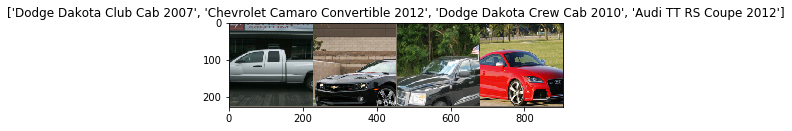

In [19]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [20]:
def train_model(model, dataloaders, criterion, scheduler, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'test':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [21]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [22]:
# Visualize the model

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [23]:
def initialize_model(model_name, num_classes, feature_extract, path):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet50()
        model_ft.load_state_dict(torch.load(path))
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0()
        model_ft.load_state_dict(torch.load(path))
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121()
        model_ft.load_state_dict(torch.load(path))
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3()
        model_ft.load_state_dict(torch.load(path))
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, path = '../input/pytorch-pretrained-image-models/resnet50.pth')

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [24]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

In [25]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [26]:
# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders, criterion,exp_lr_scheduler, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/24
----------
train Loss: 4.8521 Acc: 0.0387
test Loss: 3.5425 Acc: 0.1564

Epoch 1/24
----------
train Loss: 3.8493 Acc: 0.1384
test Loss: 2.4868 Acc: 0.3442

Epoch 2/24
----------
train Loss: 3.1819 Acc: 0.2419
test Loss: 2.0912 Acc: 0.4293

Epoch 3/24
----------
train Loss: 2.7231 Acc: 0.3320
test Loss: 1.6873 Acc: 0.5346

Epoch 4/24
----------
train Loss: 2.4249 Acc: 0.3992
test Loss: 1.5141 Acc: 0.5870

Epoch 5/24
----------
train Loss: 2.2105 Acc: 0.4468
test Loss: 1.2480 Acc: 0.6509

Epoch 6/24
----------
train Loss: 1.9944 Acc: 0.4974
test Loss: 1.1708 Acc: 0.6765

Epoch 7/24
----------
train Loss: 1.8291 Acc: 0.5282
test Loss: 1.1224 Acc: 0.6954

Epoch 8/24
----------
train Loss: 1.7205 Acc: 0.5602
test Loss: 1.0667 Acc: 0.7096

Epoch 9/24
----------
train Loss: 1.5792 Acc: 0.5930
test Loss: 0.8718 Acc: 0.7559

Epoch 10/24
----------
train Loss: 1.5257 Acc: 0.6094
test Loss: 0.9195 Acc: 0.7452

Epoch 11/24
----------
train Loss: 1.4082 Acc: 0.6283
test Loss: 0.7613 Acc

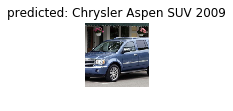

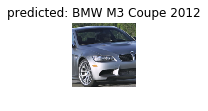

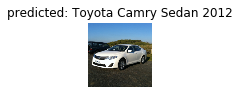

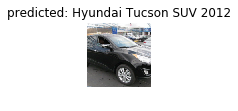

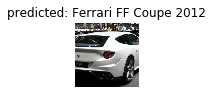

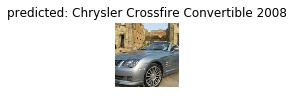

In [27]:
visualize_model(model_ft)

plt.ioff()
plt.show()

Benchmark model gives us **84.35%** Accuracy.

What's Next : 

- **95%** - WS-DAN - [See Better Before Looking Closer: Weakly Supervised Data Augmentation Network for Fine-Grained Visual Classification - Hu 2019](https://arxiv.org/abs/1901.09891)
- Try some ideas from this paper by Amazon - Bag of Tricks for Image Classification with Convolutional Neural Network: https://arxiv.org/pdf/1812.01187.pdf
- Try alternate architectures, e.g. densenet